# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [10]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

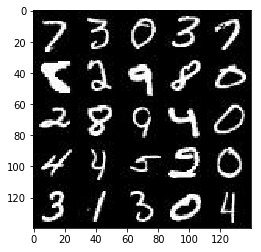

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

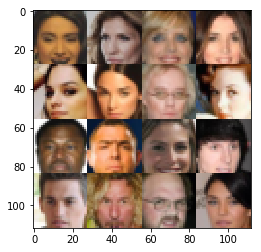

In [4]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [2]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input');
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/zmq/eventloop/ioloop.

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [83]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # Kernel size changed 3 -> 5 as sugguested by reviewer
        # Currently you're using a kernel size of 3. 
        # Normally, this can help you to generate better images, 
        # however, in our case we're training with a limited dataset and for a limited number of epoch. 
        # So I would strongly advise to use a kernel size of 5 here.
        
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(
            flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [85]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        # Reviewer: Your generator is overpowering your discriminator
        
        # L1:Starts with 4x4x256
        # L1:Starts with 3x3x512
        layer = tf.layers.dense(z, 4 * 4 * 512)
        layer = tf.reshape(layer, (-1, 4, 4, 512))
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        
        # L2
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        relu = tf.nn.relu(layer)
        # 6x6x256 now
        # 8x8x256 now
        
        # L3
        layer = tf.layers.conv2d_transpose(layer, 128, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        # 12x12x128 now
        # 16x16x256 now
        
        # L4
        layer = tf.layers.conv2d_transpose(layer, 64, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        # 24x24x64
        # 32x32x256 now

        
        # L5 Output layer
        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        # 48x48x3 now
        layer = tf.image.resize_images(layer, size=(28, 28)) 
        output = tf.nn.tanh(layer, name='generator_main')
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [89]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train = True)
    
    discriminator_real_model, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    smooth = 0.2
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits,
                                                                         labels=tf.ones_like(discriminator_real_model) * (1 - smooth)))
    
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                         labels=tf.zeros_like(discriminator_fake_model)))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                    labels = tf.ones_like(discriminator_fake_model)))
    
    return discriminator_loss, generator_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [6]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
 
    discriminator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = discriminator_vars)
    
    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(generator_dep):
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = generator_vars)
    
    return discriminator_opt, generator_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [8]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_w, image_h, out_channel_dim = data_shape
    input_ph, z_ph, lr_ph = model_inputs(image_w, image_h, out_channel_dim, z_dim)
    d_loss,g_loss = model_loss(input_ph, z_ph, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_ph, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('Epoch {}/{}'.format(epoch_i+1, epoch_count))
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_train_opt, feed_dict={
                    input_ph: batch_images,
                    z_ph: batch_z,
                    lr_ph:learning_rate})
                sess.run(g_train_opt, feed_dict={
                    z_ph: batch_z,
                    lr_ph:learning_rate})

                if steps % 16 == 0:
                    train_loss_d = d_loss.eval({z_ph: batch_z, input_ph: batch_images})
                    train_loss_g = g_loss.eval({z_ph: batch_z})

                    print("Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % batch_size == 0:
                    show_generator_output(sess, 9, z_ph, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2
Step 16... Discriminator Loss: 0.8330... Generator Loss: 5.2334
Step 32... Discriminator Loss: 2.6432... Generator Loss: 21.5172
Step 48... Discriminator Loss: 1.9762... Generator Loss: 7.3498
Step 64... Discriminator Loss: 0.9642... Generator Loss: 1.5782


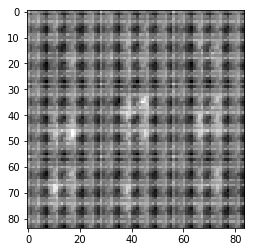

Step 80... Discriminator Loss: 1.1901... Generator Loss: 0.9813
Step 96... Discriminator Loss: 1.0091... Generator Loss: 1.3377
Step 112... Discriminator Loss: 0.9579... Generator Loss: 2.1804
Step 128... Discriminator Loss: 0.9489... Generator Loss: 1.6805


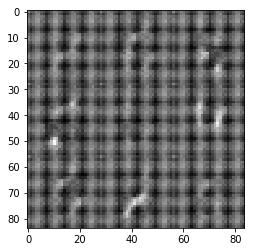

Step 144... Discriminator Loss: 1.0041... Generator Loss: 1.7181
Step 160... Discriminator Loss: 1.0045... Generator Loss: 1.3826
Step 176... Discriminator Loss: 0.9939... Generator Loss: 1.3896
Step 192... Discriminator Loss: 1.2340... Generator Loss: 3.1557


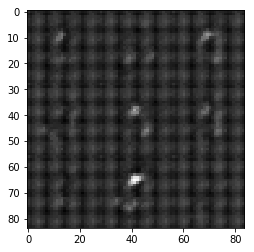

Step 208... Discriminator Loss: 0.9955... Generator Loss: 2.4175
Step 224... Discriminator Loss: 0.9157... Generator Loss: 1.8558
Step 240... Discriminator Loss: 1.1265... Generator Loss: 1.0510
Step 256... Discriminator Loss: 0.9487... Generator Loss: 1.6752


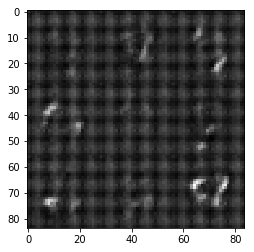

Step 272... Discriminator Loss: 0.9855... Generator Loss: 1.3288
Step 288... Discriminator Loss: 1.1719... Generator Loss: 0.9600
Step 304... Discriminator Loss: 0.9784... Generator Loss: 1.3874
Step 320... Discriminator Loss: 0.9887... Generator Loss: 1.3615


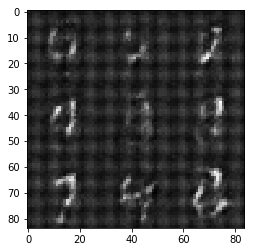

Step 336... Discriminator Loss: 1.0061... Generator Loss: 2.0539
Step 352... Discriminator Loss: 1.3944... Generator Loss: 3.2081
Step 368... Discriminator Loss: 1.0475... Generator Loss: 1.2073
Step 384... Discriminator Loss: 1.2013... Generator Loss: 2.6760


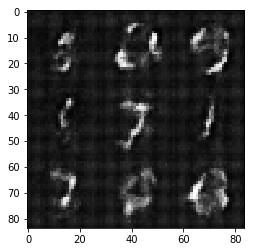

Step 400... Discriminator Loss: 1.2111... Generator Loss: 1.0073
Step 416... Discriminator Loss: 1.0623... Generator Loss: 1.1165
Step 432... Discriminator Loss: 1.1352... Generator Loss: 2.0522
Step 448... Discriminator Loss: 1.2482... Generator Loss: 0.8711


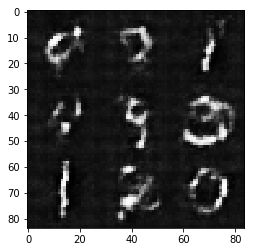

Step 464... Discriminator Loss: 1.1677... Generator Loss: 0.9348
Step 480... Discriminator Loss: 1.1725... Generator Loss: 0.9438
Step 496... Discriminator Loss: 1.2155... Generator Loss: 0.9286
Step 512... Discriminator Loss: 1.2145... Generator Loss: 2.3655


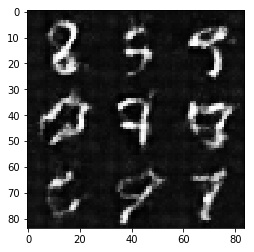

Step 528... Discriminator Loss: 1.0945... Generator Loss: 2.0394
Step 544... Discriminator Loss: 1.0626... Generator Loss: 1.1332
Step 560... Discriminator Loss: 1.1991... Generator Loss: 0.9390
Step 576... Discriminator Loss: 1.1669... Generator Loss: 0.9619


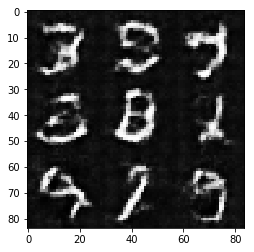

Step 592... Discriminator Loss: 1.0858... Generator Loss: 1.1476
Step 608... Discriminator Loss: 1.0610... Generator Loss: 1.4436
Step 624... Discriminator Loss: 1.5469... Generator Loss: 0.5950
Step 640... Discriminator Loss: 1.2287... Generator Loss: 0.8919


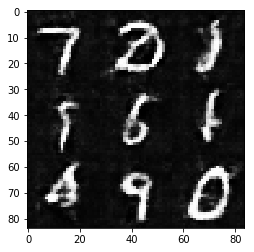

Step 656... Discriminator Loss: 1.0552... Generator Loss: 1.1927
Step 672... Discriminator Loss: 1.3531... Generator Loss: 0.7316
Step 688... Discriminator Loss: 1.4304... Generator Loss: 2.3389
Step 704... Discriminator Loss: 1.2117... Generator Loss: 2.2806


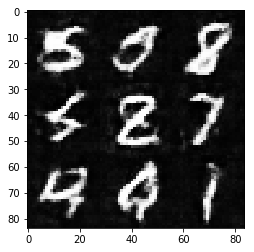

Step 720... Discriminator Loss: 1.0689... Generator Loss: 1.1973
Step 736... Discriminator Loss: 1.1687... Generator Loss: 0.9950
Step 752... Discriminator Loss: 1.0276... Generator Loss: 1.5315
Step 768... Discriminator Loss: 1.0545... Generator Loss: 1.2881


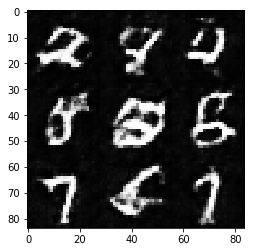

Step 784... Discriminator Loss: 1.0839... Generator Loss: 1.2464
Step 800... Discriminator Loss: 1.2306... Generator Loss: 0.9070
Step 816... Discriminator Loss: 1.2039... Generator Loss: 0.9218
Step 832... Discriminator Loss: 1.0813... Generator Loss: 1.2643


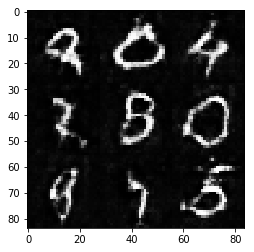

Step 848... Discriminator Loss: 1.1433... Generator Loss: 2.0730
Step 864... Discriminator Loss: 1.0529... Generator Loss: 1.3819
Step 880... Discriminator Loss: 1.1874... Generator Loss: 1.2109
Step 896... Discriminator Loss: 1.0443... Generator Loss: 1.2777


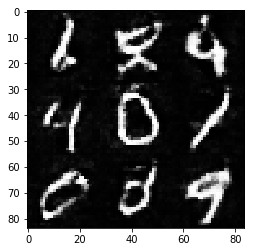

Step 912... Discriminator Loss: 1.2208... Generator Loss: 0.9561
Step 928... Discriminator Loss: 1.3505... Generator Loss: 2.1509
Epoch 2/2
Step 944... Discriminator Loss: 1.0375... Generator Loss: 1.2287
Step 960... Discriminator Loss: 1.3704... Generator Loss: 0.7251


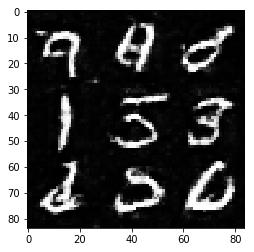

Step 976... Discriminator Loss: 1.1643... Generator Loss: 0.9831
Step 992... Discriminator Loss: 1.2557... Generator Loss: 0.8441
Step 1008... Discriminator Loss: 1.1200... Generator Loss: 1.6283
Step 1024... Discriminator Loss: 1.1025... Generator Loss: 1.1215


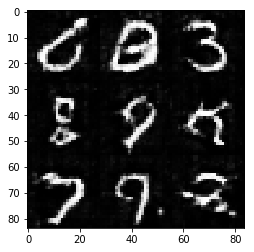

Step 1040... Discriminator Loss: 1.0929... Generator Loss: 1.3163
Step 1056... Discriminator Loss: 1.0340... Generator Loss: 1.4026
Step 1072... Discriminator Loss: 0.9865... Generator Loss: 1.6195
Step 1088... Discriminator Loss: 1.0709... Generator Loss: 1.2858


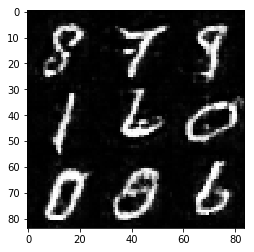

Step 1104... Discriminator Loss: 1.1485... Generator Loss: 1.1951
Step 1120... Discriminator Loss: 1.0478... Generator Loss: 1.3243
Step 1136... Discriminator Loss: 1.0857... Generator Loss: 1.2477
Step 1152... Discriminator Loss: 1.2715... Generator Loss: 0.8411


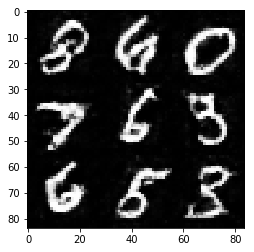

Step 1168... Discriminator Loss: 1.3258... Generator Loss: 0.7777
Step 1184... Discriminator Loss: 1.3772... Generator Loss: 0.7306
Step 1200... Discriminator Loss: 1.1528... Generator Loss: 1.0264
Step 1216... Discriminator Loss: 1.1649... Generator Loss: 1.1426


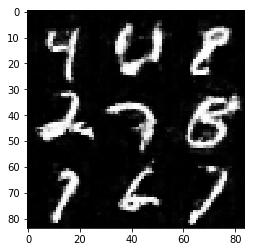

Step 1232... Discriminator Loss: 1.2166... Generator Loss: 0.8996
Step 1248... Discriminator Loss: 1.0259... Generator Loss: 1.8138
Step 1264... Discriminator Loss: 1.2209... Generator Loss: 0.8958
Step 1280... Discriminator Loss: 1.0933... Generator Loss: 1.2386


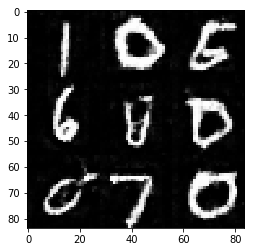

Step 1296... Discriminator Loss: 1.1056... Generator Loss: 1.1328
Step 1312... Discriminator Loss: 1.0134... Generator Loss: 1.6386
Step 1328... Discriminator Loss: 1.1104... Generator Loss: 2.1381
Step 1344... Discriminator Loss: 1.1522... Generator Loss: 1.5185


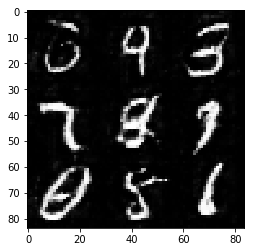

Step 1360... Discriminator Loss: 1.0953... Generator Loss: 1.7603
Step 1376... Discriminator Loss: 1.3420... Generator Loss: 2.2782
Step 1392... Discriminator Loss: 1.0538... Generator Loss: 1.3321
Step 1408... Discriminator Loss: 1.0809... Generator Loss: 1.1786


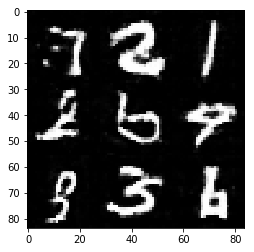

Step 1424... Discriminator Loss: 1.2576... Generator Loss: 0.9022
Step 1440... Discriminator Loss: 1.2816... Generator Loss: 0.8571
Step 1456... Discriminator Loss: 1.1216... Generator Loss: 1.1828
Step 1472... Discriminator Loss: 1.2090... Generator Loss: 2.2848


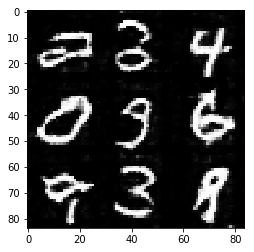

Step 1488... Discriminator Loss: 1.1698... Generator Loss: 0.9797
Step 1504... Discriminator Loss: 1.1054... Generator Loss: 1.6370
Step 1520... Discriminator Loss: 1.0492... Generator Loss: 1.9834
Step 1536... Discriminator Loss: 1.0878... Generator Loss: 1.1980


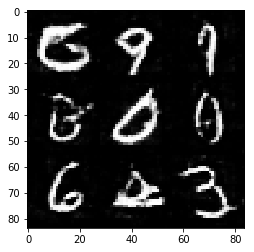

Step 1552... Discriminator Loss: 1.1109... Generator Loss: 1.0684
Step 1568... Discriminator Loss: 1.0602... Generator Loss: 1.7452
Step 1584... Discriminator Loss: 1.0243... Generator Loss: 1.7152
Step 1600... Discriminator Loss: 1.0554... Generator Loss: 1.1977


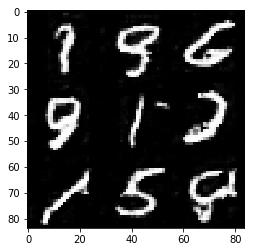

Step 1616... Discriminator Loss: 0.9957... Generator Loss: 1.6179
Step 1632... Discriminator Loss: 1.1397... Generator Loss: 1.0054
Step 1648... Discriminator Loss: 0.9768... Generator Loss: 1.6413
Step 1664... Discriminator Loss: 1.3877... Generator Loss: 2.6458


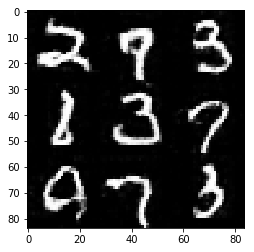

Step 1680... Discriminator Loss: 1.0240... Generator Loss: 1.6052
Step 1696... Discriminator Loss: 0.9972... Generator Loss: 1.6308
Step 1712... Discriminator Loss: 1.3640... Generator Loss: 0.7968
Step 1728... Discriminator Loss: 1.1672... Generator Loss: 1.0144


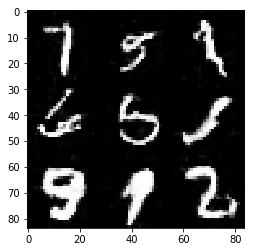

Step 1744... Discriminator Loss: 1.0680... Generator Loss: 1.2003
Step 1760... Discriminator Loss: 1.1498... Generator Loss: 0.9867
Step 1776... Discriminator Loss: 1.0865... Generator Loss: 1.4239
Step 1792... Discriminator Loss: 1.0655... Generator Loss: 1.1724


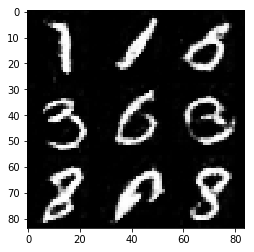

Step 1808... Discriminator Loss: 1.2410... Generator Loss: 0.9044
Step 1824... Discriminator Loss: 1.2655... Generator Loss: 0.8666
Step 1840... Discriminator Loss: 1.2498... Generator Loss: 0.8883
Step 1856... Discriminator Loss: 1.0545... Generator Loss: 1.1908


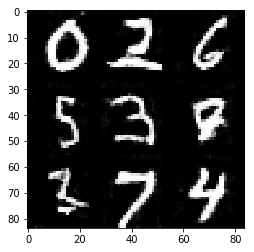

Step 1872... Discriminator Loss: 1.0433... Generator Loss: 1.2826


In [88]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1
Step 16... Discriminator Loss: 0.8222... Generator Loss: 1.8482
Step 32... Discriminator Loss: 0.8230... Generator Loss: 10.4841
Step 48... Discriminator Loss: 0.8306... Generator Loss: 13.7385
Step 64... Discriminator Loss: 1.0919... Generator Loss: 5.1106


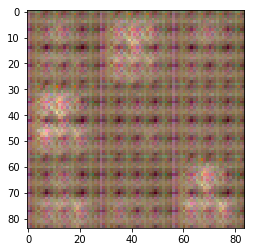

Step 80... Discriminator Loss: 1.1281... Generator Loss: 1.1982
Step 96... Discriminator Loss: 3.3198... Generator Loss: 6.8375
Step 112... Discriminator Loss: 1.6104... Generator Loss: 0.7191
Step 128... Discriminator Loss: 1.1858... Generator Loss: 0.9606


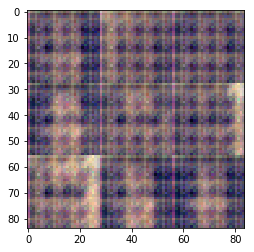

Step 144... Discriminator Loss: 2.0794... Generator Loss: 0.3036
Step 160... Discriminator Loss: 1.2178... Generator Loss: 0.8534
Step 176... Discriminator Loss: 1.3907... Generator Loss: 2.0604
Step 192... Discriminator Loss: 1.3658... Generator Loss: 1.9069


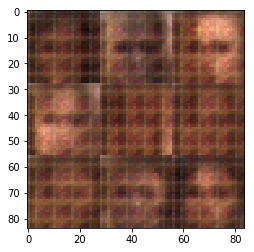

Step 208... Discriminator Loss: 1.0839... Generator Loss: 1.0587
Step 224... Discriminator Loss: 1.2700... Generator Loss: 0.8792
Step 240... Discriminator Loss: 1.1089... Generator Loss: 1.0513
Step 256... Discriminator Loss: 1.2455... Generator Loss: 0.8781


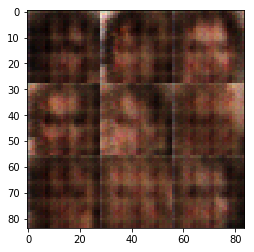

Step 272... Discriminator Loss: 1.4881... Generator Loss: 0.5681
Step 288... Discriminator Loss: 1.5697... Generator Loss: 0.4901
Step 304... Discriminator Loss: 1.1114... Generator Loss: 1.0409
Step 320... Discriminator Loss: 1.3565... Generator Loss: 1.6758


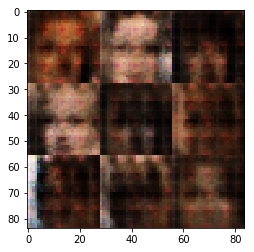

Step 336... Discriminator Loss: 1.2597... Generator Loss: 1.3251
Step 352... Discriminator Loss: 1.3254... Generator Loss: 1.7850
Step 368... Discriminator Loss: 1.1848... Generator Loss: 1.0194
Step 384... Discriminator Loss: 1.2760... Generator Loss: 1.3920


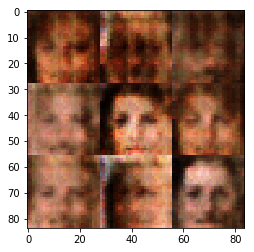

Step 400... Discriminator Loss: 1.3349... Generator Loss: 1.6960
Step 416... Discriminator Loss: 1.3107... Generator Loss: 0.7622
Step 432... Discriminator Loss: 1.2119... Generator Loss: 1.1252
Step 448... Discriminator Loss: 1.3285... Generator Loss: 0.6819


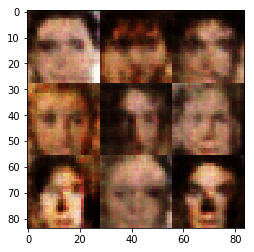

Step 464... Discriminator Loss: 1.2636... Generator Loss: 0.8555
Step 480... Discriminator Loss: 1.2214... Generator Loss: 1.6015
Step 496... Discriminator Loss: 1.3342... Generator Loss: 0.6849
Step 512... Discriminator Loss: 1.1237... Generator Loss: 1.3918


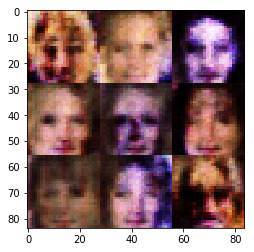

Step 528... Discriminator Loss: 1.3311... Generator Loss: 0.7055
Step 544... Discriminator Loss: 1.2308... Generator Loss: 1.0640
Step 560... Discriminator Loss: 1.0798... Generator Loss: 1.0345
Step 576... Discriminator Loss: 1.2874... Generator Loss: 0.8938


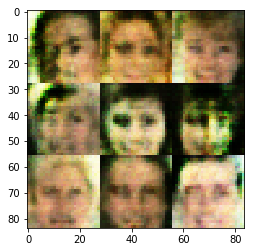

Step 592... Discriminator Loss: 1.5489... Generator Loss: 2.1073
Step 608... Discriminator Loss: 1.2438... Generator Loss: 1.3454
Step 624... Discriminator Loss: 1.2258... Generator Loss: 1.1492
Step 640... Discriminator Loss: 1.4104... Generator Loss: 0.7141


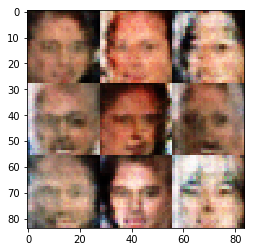

Step 656... Discriminator Loss: 1.3086... Generator Loss: 0.8216
Step 672... Discriminator Loss: 1.3134... Generator Loss: 0.9835
Step 688... Discriminator Loss: 1.2335... Generator Loss: 1.0026
Step 704... Discriminator Loss: 1.1442... Generator Loss: 1.1686


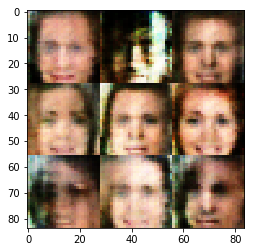

Step 720... Discriminator Loss: 1.2367... Generator Loss: 1.2102
Step 736... Discriminator Loss: 1.2004... Generator Loss: 1.1235
Step 752... Discriminator Loss: 1.2473... Generator Loss: 0.8632
Step 768... Discriminator Loss: 1.2593... Generator Loss: 0.7864


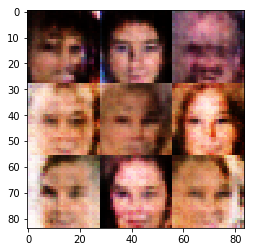

Step 784... Discriminator Loss: 1.3153... Generator Loss: 0.9853
Step 800... Discriminator Loss: 1.6725... Generator Loss: 0.4611
Step 816... Discriminator Loss: 1.2462... Generator Loss: 1.2314
Step 832... Discriminator Loss: 1.2963... Generator Loss: 0.7707


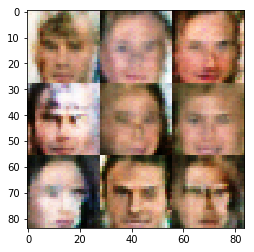

Step 848... Discriminator Loss: 1.2668... Generator Loss: 0.9887
Step 864... Discriminator Loss: 1.3793... Generator Loss: 0.6245
Step 880... Discriminator Loss: 1.2932... Generator Loss: 0.8052
Step 896... Discriminator Loss: 1.1368... Generator Loss: 0.9733


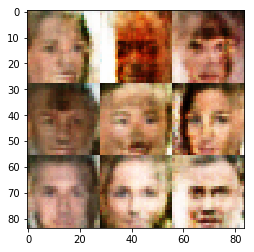

Step 912... Discriminator Loss: 1.2473... Generator Loss: 1.0495
Step 928... Discriminator Loss: 1.3857... Generator Loss: 0.6543
Step 944... Discriminator Loss: 1.2441... Generator Loss: 0.9557
Step 960... Discriminator Loss: 1.5206... Generator Loss: 1.8346


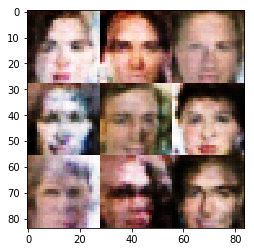

Step 976... Discriminator Loss: 1.1746... Generator Loss: 1.0115
Step 992... Discriminator Loss: 1.2553... Generator Loss: 1.0020
Step 1008... Discriminator Loss: 1.1480... Generator Loss: 1.1004
Step 1024... Discriminator Loss: 1.2793... Generator Loss: 0.7135


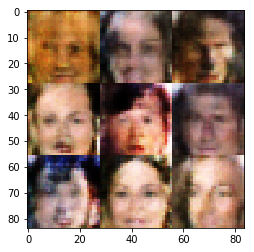

Step 1040... Discriminator Loss: 1.3254... Generator Loss: 0.7129
Step 1056... Discriminator Loss: 1.1743... Generator Loss: 1.2140
Step 1072... Discriminator Loss: 1.2980... Generator Loss: 1.5501
Step 1088... Discriminator Loss: 1.2830... Generator Loss: 0.7700


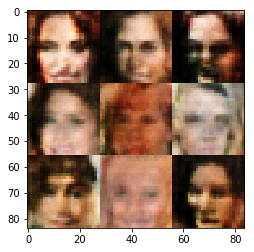

Step 1104... Discriminator Loss: 1.1713... Generator Loss: 1.3258
Step 1120... Discriminator Loss: 1.2375... Generator Loss: 1.3416
Step 1136... Discriminator Loss: 1.1915... Generator Loss: 1.0336
Step 1152... Discriminator Loss: 1.2755... Generator Loss: 1.2225


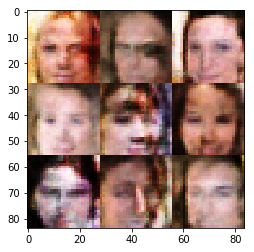

Step 1168... Discriminator Loss: 1.2832... Generator Loss: 1.3224
Step 1184... Discriminator Loss: 1.5931... Generator Loss: 1.7455
Step 1200... Discriminator Loss: 1.2236... Generator Loss: 1.0313
Step 1216... Discriminator Loss: 1.3012... Generator Loss: 1.4774


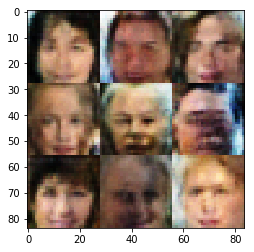

Step 1232... Discriminator Loss: 1.2656... Generator Loss: 1.0282
Step 1248... Discriminator Loss: 1.4593... Generator Loss: 0.5854
Step 1264... Discriminator Loss: 1.2720... Generator Loss: 0.7224
Step 1280... Discriminator Loss: 1.2029... Generator Loss: 1.3177


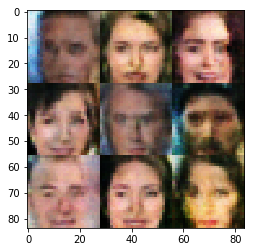

Step 1296... Discriminator Loss: 1.5359... Generator Loss: 0.5123
Step 1312... Discriminator Loss: 1.4592... Generator Loss: 0.5551
Step 1328... Discriminator Loss: 1.3264... Generator Loss: 0.8454
Step 1344... Discriminator Loss: 1.3586... Generator Loss: 1.8060


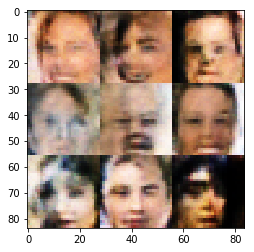

Step 1360... Discriminator Loss: 1.0965... Generator Loss: 1.2706
Step 1376... Discriminator Loss: 1.2338... Generator Loss: 0.8501
Step 1392... Discriminator Loss: 1.3337... Generator Loss: 0.7844
Step 1408... Discriminator Loss: 1.2873... Generator Loss: 0.7296


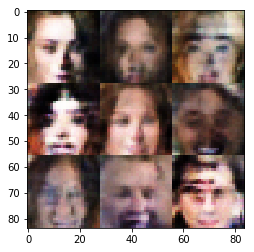

Step 1424... Discriminator Loss: 1.2916... Generator Loss: 0.7425
Step 1440... Discriminator Loss: 1.2524... Generator Loss: 0.8780
Step 1456... Discriminator Loss: 1.2818... Generator Loss: 0.7907
Step 1472... Discriminator Loss: 1.2669... Generator Loss: 0.9669


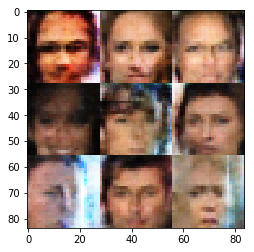

Step 1488... Discriminator Loss: 1.2282... Generator Loss: 1.1400
Step 1504... Discriminator Loss: 1.4597... Generator Loss: 0.5840
Step 1520... Discriminator Loss: 1.2178... Generator Loss: 1.0951
Step 1536... Discriminator Loss: 1.1036... Generator Loss: 1.2132


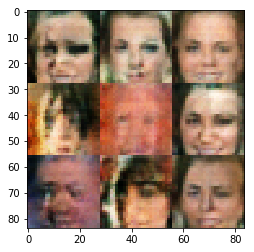

Step 1552... Discriminator Loss: 1.2494... Generator Loss: 0.8832
Step 1568... Discriminator Loss: 1.1595... Generator Loss: 1.2090
Step 1584... Discriminator Loss: 1.2497... Generator Loss: 0.7884
Step 1600... Discriminator Loss: 1.3650... Generator Loss: 0.6974


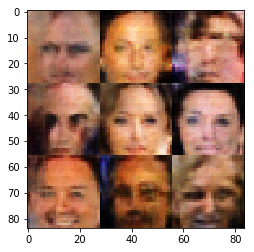

Step 1616... Discriminator Loss: 1.1671... Generator Loss: 1.2175
Step 1632... Discriminator Loss: 1.2884... Generator Loss: 0.7631
Step 1648... Discriminator Loss: 1.3122... Generator Loss: 1.5024
Step 1664... Discriminator Loss: 1.4075... Generator Loss: 0.6205


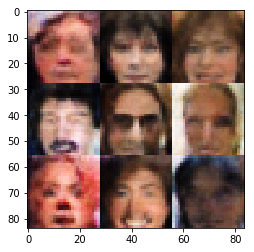

Step 1680... Discriminator Loss: 1.2363... Generator Loss: 0.8771
Step 1696... Discriminator Loss: 1.1287... Generator Loss: 1.0127
Step 1712... Discriminator Loss: 1.2109... Generator Loss: 1.0673
Step 1728... Discriminator Loss: 1.1880... Generator Loss: 0.9167


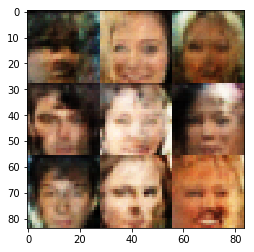

Step 1744... Discriminator Loss: 1.2102... Generator Loss: 0.9373
Step 1760... Discriminator Loss: 1.3219... Generator Loss: 0.7097
Step 1776... Discriminator Loss: 1.1776... Generator Loss: 1.2119
Step 1792... Discriminator Loss: 1.2379... Generator Loss: 0.8895


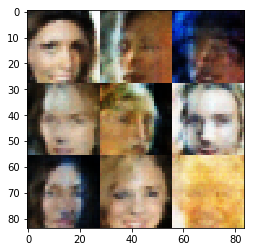

Step 1808... Discriminator Loss: 1.3921... Generator Loss: 0.5819
Step 1824... Discriminator Loss: 1.2575... Generator Loss: 0.9911
Step 1840... Discriminator Loss: 1.3047... Generator Loss: 1.3053
Step 1856... Discriminator Loss: 1.2353... Generator Loss: 0.7923


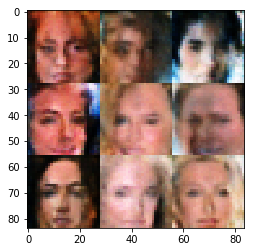

Step 1872... Discriminator Loss: 1.2341... Generator Loss: 1.3657
Step 1888... Discriminator Loss: 1.2705... Generator Loss: 1.2217
Step 1904... Discriminator Loss: 1.2566... Generator Loss: 1.4377
Step 1920... Discriminator Loss: 1.1623... Generator Loss: 0.9543


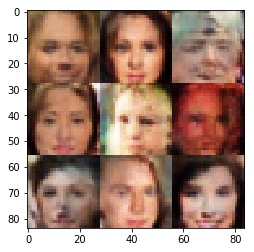

Step 1936... Discriminator Loss: 1.3879... Generator Loss: 0.6573
Step 1952... Discriminator Loss: 1.1082... Generator Loss: 1.0314
Step 1968... Discriminator Loss: 1.4497... Generator Loss: 0.5603
Step 1984... Discriminator Loss: 1.3272... Generator Loss: 0.7340


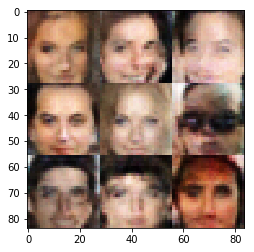

Step 2000... Discriminator Loss: 1.0474... Generator Loss: 1.4653
Step 2016... Discriminator Loss: 1.2152... Generator Loss: 0.8989
Step 2032... Discriminator Loss: 1.2502... Generator Loss: 0.9781
Step 2048... Discriminator Loss: 1.1296... Generator Loss: 1.2067


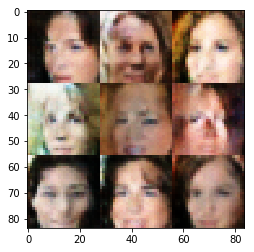

Step 2064... Discriminator Loss: 1.2695... Generator Loss: 0.9534
Step 2080... Discriminator Loss: 1.3783... Generator Loss: 0.6710
Step 2096... Discriminator Loss: 1.2441... Generator Loss: 1.1821
Step 2112... Discriminator Loss: 1.2872... Generator Loss: 0.7070


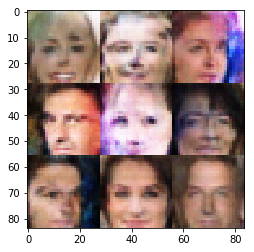

Step 2128... Discriminator Loss: 1.4543... Generator Loss: 0.5853
Step 2144... Discriminator Loss: 1.2601... Generator Loss: 0.8368
Step 2160... Discriminator Loss: 1.2783... Generator Loss: 1.2558
Step 2176... Discriminator Loss: 1.2106... Generator Loss: 0.8595


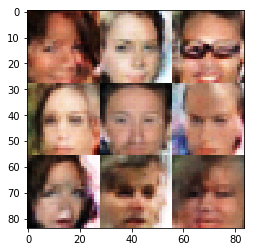

Step 2192... Discriminator Loss: 1.2337... Generator Loss: 1.3577
Step 2208... Discriminator Loss: 1.3074... Generator Loss: 0.7002
Step 2224... Discriminator Loss: 1.2818... Generator Loss: 1.0156
Step 2240... Discriminator Loss: 1.1387... Generator Loss: 1.2153


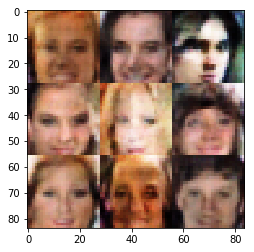

Step 2256... Discriminator Loss: 1.3692... Generator Loss: 0.6893
Step 2272... Discriminator Loss: 1.3745... Generator Loss: 0.6449
Step 2288... Discriminator Loss: 1.2866... Generator Loss: 0.7051
Step 2304... Discriminator Loss: 1.3247... Generator Loss: 0.7175


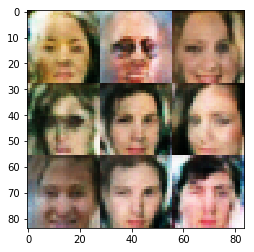

Step 2320... Discriminator Loss: 1.2994... Generator Loss: 0.7321
Step 2336... Discriminator Loss: 1.2658... Generator Loss: 1.0216
Step 2352... Discriminator Loss: 1.2643... Generator Loss: 0.8896
Step 2368... Discriminator Loss: 1.2230... Generator Loss: 1.3549


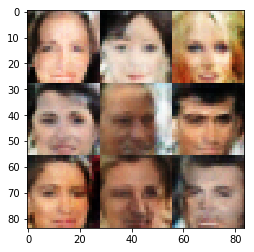

Step 2384... Discriminator Loss: 1.2754... Generator Loss: 0.7957
Step 2400... Discriminator Loss: 1.2038... Generator Loss: 0.7978
Step 2416... Discriminator Loss: 1.4536... Generator Loss: 0.5831
Step 2432... Discriminator Loss: 1.3371... Generator Loss: 0.6876


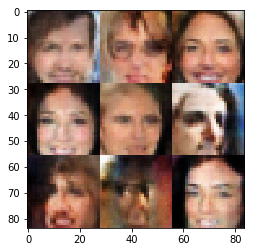

Step 2448... Discriminator Loss: 1.1683... Generator Loss: 1.1968
Step 2464... Discriminator Loss: 1.2958... Generator Loss: 0.9307
Step 2480... Discriminator Loss: 1.3031... Generator Loss: 0.7329
Step 2496... Discriminator Loss: 1.1877... Generator Loss: 1.0913


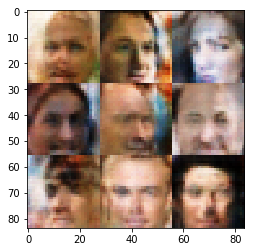

Step 2512... Discriminator Loss: 1.4599... Generator Loss: 0.6194
Step 2528... Discriminator Loss: 1.4376... Generator Loss: 1.2794
Step 2544... Discriminator Loss: 1.4181... Generator Loss: 0.5877
Step 2560... Discriminator Loss: 1.1788... Generator Loss: 0.9753


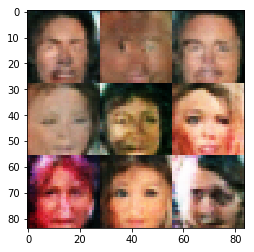

Step 2576... Discriminator Loss: 1.2391... Generator Loss: 1.2516
Step 2592... Discriminator Loss: 1.2774... Generator Loss: 0.7295
Step 2608... Discriminator Loss: 1.2069... Generator Loss: 1.0375
Step 2624... Discriminator Loss: 1.3706... Generator Loss: 0.6343


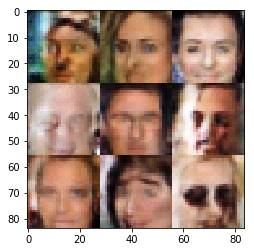

Step 2640... Discriminator Loss: 1.2539... Generator Loss: 0.9028
Step 2656... Discriminator Loss: 1.2820... Generator Loss: 1.0404
Step 2672... Discriminator Loss: 1.3430... Generator Loss: 0.6919
Step 2688... Discriminator Loss: 1.2036... Generator Loss: 0.8247


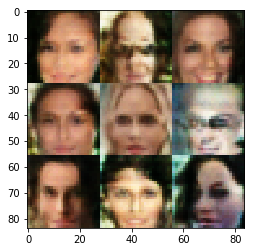

Step 2704... Discriminator Loss: 1.5283... Generator Loss: 0.5428
Step 2720... Discriminator Loss: 1.3668... Generator Loss: 0.6953
Step 2736... Discriminator Loss: 1.4224... Generator Loss: 0.5979
Step 2752... Discriminator Loss: 1.2834... Generator Loss: 0.8102


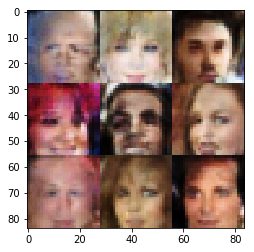

Step 2768... Discriminator Loss: 1.1577... Generator Loss: 0.9936
Step 2784... Discriminator Loss: 1.2751... Generator Loss: 0.8065
Step 2800... Discriminator Loss: 1.4596... Generator Loss: 0.5469
Step 2816... Discriminator Loss: 1.4355... Generator Loss: 0.6221


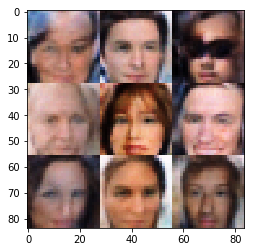

Step 2832... Discriminator Loss: 1.3310... Generator Loss: 0.7610
Step 2848... Discriminator Loss: 1.1908... Generator Loss: 0.9898
Step 2864... Discriminator Loss: 1.5736... Generator Loss: 0.4894
Step 2880... Discriminator Loss: 1.3240... Generator Loss: 0.7451


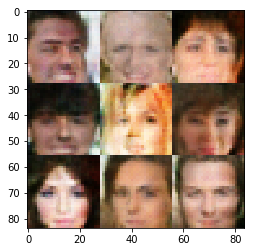

Step 2896... Discriminator Loss: 1.4365... Generator Loss: 0.5702
Step 2912... Discriminator Loss: 1.2741... Generator Loss: 0.9498
Step 2928... Discriminator Loss: 1.3011... Generator Loss: 0.7696
Step 2944... Discriminator Loss: 1.4677... Generator Loss: 0.5365


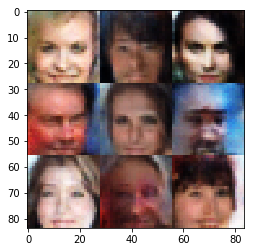

Step 2960... Discriminator Loss: 1.1908... Generator Loss: 0.9242
Step 2976... Discriminator Loss: 1.2039... Generator Loss: 1.0988
Step 2992... Discriminator Loss: 1.1391... Generator Loss: 1.1103
Step 3008... Discriminator Loss: 1.4165... Generator Loss: 1.1732


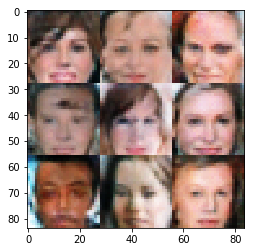

Step 3024... Discriminator Loss: 1.1847... Generator Loss: 1.3296
Step 3040... Discriminator Loss: 1.4535... Generator Loss: 0.5813
Step 3056... Discriminator Loss: 1.2032... Generator Loss: 0.9322
Step 3072... Discriminator Loss: 1.1370... Generator Loss: 0.9533


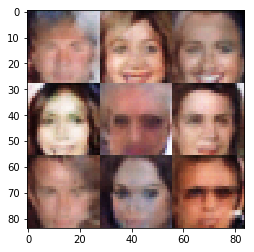

Step 3088... Discriminator Loss: 1.2588... Generator Loss: 0.8106
Step 3104... Discriminator Loss: 1.3585... Generator Loss: 0.7360
Step 3120... Discriminator Loss: 1.1761... Generator Loss: 0.9454
Step 3136... Discriminator Loss: 1.2558... Generator Loss: 1.0989


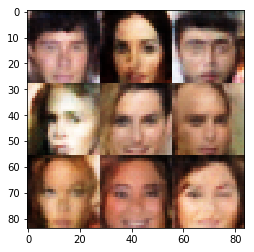

Step 3152... Discriminator Loss: 1.3185... Generator Loss: 0.7349


In [90]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.